# devlog 2024-08-30

Testing non-returner movement support.

This is basically allowing movement models to specify a "null" return time, modeling individuals that migrate on a more-or-less permanent basis to wherever they're moving.

In [1]:
import numpy as np
from numpy.typing import NDArray
from typing_extensions import override

from epymorph import *
from epymorph.movement_model import EveryDay, MovementClause, MovementModel
from epymorph.simulation import NEVER, Tick, TickDelta, TickIndex


class RandomWalk(MovementClause):
    _abstract_simfunc = True

    @override
    def evaluate(self, tick: Tick) -> NDArray[np.int64]:
        N = self.dim.nodes
        pop = self.data("population")

        # Approx 5% of each node's population moves
        # (as reckoned by the starting population),
        # except for the last node where no one moves.
        movers = self.rng.binomial(pop, 0.05)

        matrix = np.zeros((N, N), dtype=np.int64)
        # The first node moves folks to the next node.
        matrix[0, 1] = movers[0]
        # Each middle node moves folks randomly left or right with even probability.
        left = self.rng.binomial(movers, 0.5)
        right = movers - left
        for n in range(1, N - 1):
            matrix[n, n - 1] = left[n]
            matrix[n, n + 1] = right[n]
        # The last node doesn't move anyone.
        return matrix


class MCA(RandomWalk):
    requirements = (AttributeDef("population", int, Shapes.N),)
    predicate = EveryDay()
    leaves = TickIndex(0)
    returns = TickDelta(days=0, step=0)


class MovementA(MovementModel):
    steps = (1.0,)
    clauses = (MCA(),)


class MCB(RandomWalk):
    requirements = (AttributeDef("population", int, Shapes.N),)
    predicate = EveryDay()
    leaves = TickIndex(0)
    returns = NEVER


class MovementB(MovementModel):
    steps = (1.0,)
    clauses = (MCB(),)

In [2]:
import matplotlib.pyplot as plt

from epymorph.simulator.basic.output import Output


def plot_pops(out: Output) -> None:
    fig, ax = plt.subplots()
    ax.set_title("Population at each node over time")
    ax.set_xlabel("days")
    ax.set_ylabel("individuals")
    x_axis = out.ticks_in_days
    y_axis = out.prevalence[:, :, 0]
    ax.plot(x_axis, y_axis, label=out.geo_labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

In [3]:
from epymorph.geography.scope import CustomScope
from epymorph.log.movement import movement_data

scope = CustomScope(["A", "B", "C"])
population = np.full(shape=scope.nodes, fill_value=1000, dtype=np.int64)

Running simulation (BasicSimulator):
• 2020-01-01 to 2020-04-30 (120 days)
• 3 geo nodes
|####################| 100% 
Runtime: 0.053s


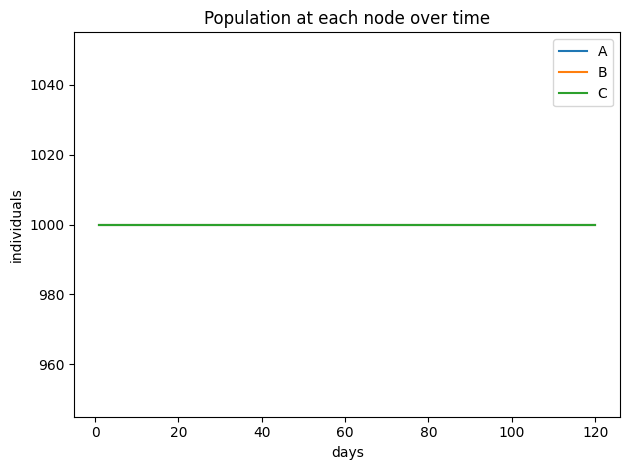

In [4]:
rume = SingleStrataRume.build(
    ipm=ipm_library["no"](),
    mm=MovementA(),
    init=init.Explicit(population[:, np.newaxis]),
    scope=scope,
    time_frame=TimeFrame.of("2020-01-01", 120),
    params={"population": population},
)

sim = BasicSimulator(rume)
with sim_messaging(), movement_data() as mvt:
    out = sim.run()


plot_pops(out)

Running simulation (BasicSimulator):
• 2020-01-01 to 2020-04-30 (120 days)
• 3 geo nodes
|####################| 100% 
Runtime: 0.032s


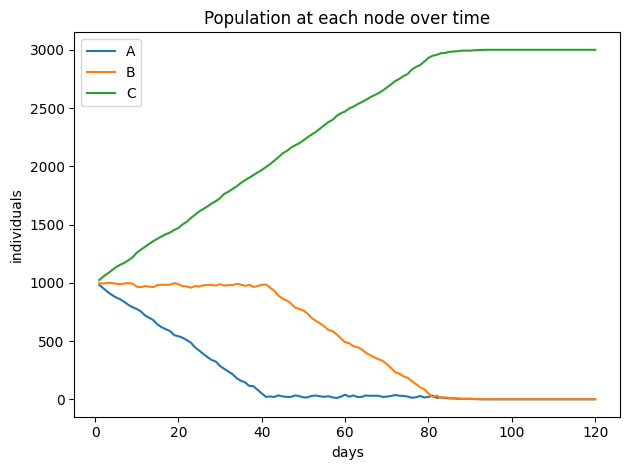

In [5]:
rume = SingleStrataRume.build(
    ipm=ipm_library["no"](),
    mm=MovementB(),
    init=init.Explicit(population[:, np.newaxis]),
    scope=scope,
    time_frame=TimeFrame.of("2020-01-01", 120),
    params={
        "population": population,
    },
)

sim = BasicSimulator(rume)
with sim_messaging(), movement_data() as mvt:
    out = sim.run()


plot_pops(out)

In [6]:
print("the return clause should move a total of 0 people: ")
print(mvt.actual_by("return").sum())

print("\neveryone from A and B should have moved into C (2000):")
print(mvt.actual_by("MCB").sum(axis=(0, 1))[2, 0])

the return clause should move a total of 0 people: 
0

everyone from A and B should have moved into C (2000):
2000
